# Rediscovering Simon's algorithm with PQC
**Table of contents**

- [Introduction](#Introduction)
  - [Simon's problem (classical version)](#Simon's-problem-(classical-version))
  - [Simon's problem (quantum version)](#Simon's-problem-(quantum-version))
- [Simon's algorithm](#Simon's-algorithm)
  - [Implement Simon's algorithm with QuAIRKit](#Implement-Simon's-algorithm-with-QuAIRKit)
  - [Begin experiment](#Begin-experiment)
- [References](#References)

In [1]:
from typing import Callable
import numpy as np

import torch
import quairkit as qkit
from quairkit import Circuit
from quairkit.database import *
from quairkit.loss import *
from quairkit.qinfo import *

import time

## Introduction
Simon's algorithm is a quantum algorithm for obtaining the period of a vectorial Boolean function with polynomial time complexity, achieving exponential speedup over classical algorithms [1]. 


Although Simon's algorithm has few general applications, it inspired the discovery of Shor's algorithm. In fact, the two problems solved by these two algorithms are both special cases of the abelian hidden subgroup problem.
Before presenting Simon's algorithm, let's first review Simon's problem.

### Simon's problem (classical version)

Input: a function $f: \{0, 1\}^n \to \{0, 1\}^n$ that satisfies for all $n$-bit string $x$ and $y$: $f(x) = f(y)$ if and only if $x = y$ or $x = y \oplus s$ for some $n$-bit string $s$.

Output: determine $s \in \{0, 1\}^n$.

Any classical algorithm solving this should require $\Omega(2^{n/2})$ queries, while Simon's algorithm solves it in $\mathcal{O}(n) $ quantum queries [2].

Such function $f$ can be randomly generated via the following function.

In [2]:
def simon_function(n: int, s: int) -> Callable[[int], int]:
    r"""Generates a function f such that :math:`f(x) = f(y)` if and only if :math:`y = x` or :math:`y = x \oplus s`.

    Args:
        n: the number of bits in the input and output strings.
        s: an integer represented by an n-bit string representing the secret string in Simon's problem.

    Returns:
        A matrix f mapping integers to integers satisfying Simon's problem properties.
    """
    # generate a random permutation of 0, 1, ..., 2^n-1
    all_x = np.arange(2 ** n)
    np.random.shuffle(all_x)
    
    mapping = {}
    outputs_used = set()
    
    # generate a mapping, which implements function f
    for x in all_x:
        if x in mapping:
            continue
        
        # Generate a random output not used before
        while True:
            fx = np.random.randint(2 ** n)
            if fx not in outputs_used:
                outputs_used.add(fx)
                break
        
        # since f(x) = f(x \oplus s)
        mapping[x] = fx
        mapping[x ^ s] = fx

    # Define the function f using the mapping
    def f(input_int: int) -> int:
        return mapping[input_int]

    return f

Below is an example of a function $f$ for $n = 2$ and $s = 11$.

In [3]:
n = 2
s_str = '11'
# get function f with n and s_str
example_f = simon_function(n, int(s_str, 2))
# print the value of f(x) for every x
print(" x | f(x)")
for x in range(2 ** n): 
    result = bin(example_f(x))[2:].zfill(n)
    x = bin(x)[2:].zfill(n)
    print(f"{x} | {result}")

 x | f(x)
00 | 10
01 | 11
10 | 11
11 | 10


We can find that $f(00) =  f(00 \oplus 11)$, $f(01)=f(01\oplus 11)$, etc.

Now, let's go over the quantum version of Simon's problem.

### Simon's problem (quantum version)

Input: an access to unitary $U_f$ that implements the function $f$.

Output: an $n$-bit string $y$ such that $y \cdot s = 0$, where $\cdot$ is the inner product over $\mathbb{Z}_2$, i.e. the bitwise inner product of $y$ and $s$.

Now it's time to present the steps of Simon's algorithm.

## Simon's algorithm
We begin to show how to find this hidden integer $s$.
1. Initialize $2n$ qubits as two quantum registers of length $n$, simplified as $\ket{0}^{\otimes n}\ket{0}^{\otimes n}=\ket{0}\ket{0}$.

2. Apply Hadamard gates to first register to get 
$$
(H^{\otimes n} \otimes I) \ket{0}\ket{0} = \frac{1}{2^{n/2}} \sum_{x=0}^{2^n-1}\ket{x}\ket{0}.\tag{1}
$$

3. Query the blackbox unitary $U_f$ to get
$$
U_f\,\frac{1}{2^{n/2}} \sum_{x=0}^{2^n-1}\ket{x}\ket{0} = \frac{1}{2^{n/2}} \sum_{x=0}^{2^n-1}\ket{x}\ket{f(x)}.\tag{2}
$$

4. Apply Hadamard gates to first register again, and the state becomes
$$
(H^{\otimes n} \otimes I)\, \frac{1}{2^{n/2}} \sum_{x=0}^{2^n-1}\ket{x}\ket{f(x)}
=\frac{1}{2^n} \sum_{y=0}^{2^n-1}\sum_{x=0}^{2^n-1} (-1)^{x \cdot y}\ket{y} \ket{f(x)}.\tag{3}
$$
Here we consider the amplitude of $\ket{y} \ket{f(x)}$. Due to $f(x)=f(x\oplus s)$, sum the only two terms that attribute to the amplitude of $\ket{y} \ket{f(x)}$ as 
$$
\frac{1}{2^n}\Bigl( (-1)^{x\cdot y} +(-1)^{(x\oplus s)\cdot y}\Bigr).\tag{4}
$$
With the distributive law as $(x\oplus s)\cdot y=x\cdot y \oplus s\cdot y$, we get 
$$
\begin{aligned}
\frac{1}{2^n}\Bigl( (-1)^{x\cdot y} +(-1)^{(x\oplus s)\cdot y}\Bigr)
& = \frac{1}{2^n}\bigl( (-1)^{x\cdot y} +(-1)^{x\cdot y \oplus s\cdot y}\bigr)\\
& = \frac{1}{2^n}\bigl( (-1)^{x\cdot y} +(-1)^{x\cdot y} (-1)^{s\cdot y}\bigr)\\
& = \frac{1}{2^n}(-1)^{x\cdot y} \bigl( 1 + (-1)^{s\cdot y} \bigr).
\end{aligned}
$$
This shows that no outcome $y$ with $s\cdot y=1$ is observable, whereas outcomes satisfying $s\cdot y=0$ occur with probability $2^{2-2n}$.

5. Repeat Step 1 to 4 to obtain a list of $y$ satisfying $s\cdot y=0$, which can be used to get $s$ by solving a system of linear equations.

### Implement Simon's algorithm with QuAIRKit
First, we should construct a $U_f$ for later usage. Here is an example that implements the oracle for this $f$:
| $x$ | $f(x)$ |
|------|---------|
| $00$ | $00$|
| $01$ | $01$|
| $10$ | $00$|
| $11$ | $01$|

We can find $f(x)=f(x\oplus 10)$.


In [4]:
def oracle_example() -> Circuit:
    r"""generate this oracle with n = 2 and s = '10'.
    
    Returns:
        the circuit for Simon's problem with n = 2 and s = '10'.
    
    """
    n = 2
    qc = Circuit(2 * n)
    qc.cx([0, 1])  # the effect of this oracle is exactly only a cnot gate.
    return qc

Then, we construct the Simon's circuit in Step 1 to Step 4.

In [5]:
def simon_circuit(n: int, oracle: Circuit) -> Circuit:
    r""" Simon's circuit for corresponding oracle.
    
    Args:
        n: the number of qubits in the Simon's problem.
        oracle: the oracle circuit implementing the Simon's problem.
    
    Returns:
        A circuit implementing Simon's algorithm.
    
    """
    simon_cir = Circuit(2 * n)  # Step 1
    simon_cir.h(list(range(n)))  # Step 2
    simon_cir.extend(oracle)  # Step 3
    simon_cir.h(list(range(n)))  # Step 4
    return simon_cir

We can plot the circuit like this.

the diagram of the quantum circuit in this case:


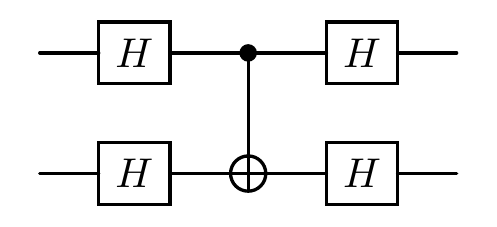

In [6]:
# plot this circuit
print("the diagram of the quantum circuit in this case:")
cir = simon_circuit(2, oracle_example())
cir.plot()

## Using PQC to rediscover Simon's algorithm
Parameterized quantum circuits (PQC) are circuits with tunable parameters, like rotation angles. They are central to hybrid algorithms like QAOA.

We begin by using PQC to rediscover Simon’s problem.

Define $P^\perp(s) = \sum_{y: y \cdot s = 0} \ket{y}\bra{y}$. We expect the measurement outcome of this circuit to be orthogonal to $s$. That is, applying the projector $I - P^\perp(s)$ to the output state should output 0.
Then the loss function is defined as
$$
\begin{aligned}
\mathcal{L}(\theta) &= \textrm{Average probability of measurement outcome } \in \{y: y \cdot s \neq 0 \} \\
&= \frac{1}{N} \sum_{i=0}^{N - 1} \left| \left(I - P^\perp(s_i)\right) \cdot C_\theta(f_i) \ket{0} \right|^2
, 
\end{aligned}
$$
where $C_\theta(f_i)$ is the output unitary of the parameterized comb $C_\theta$ with input unitary $U_{f_i}$.

We first randomly generate `list_f`.

In [7]:
num_data = 1000  # number of data

# Generate a batch of random secret strings and corresponding functions.
dim = 2 ** n
list_s = np.random.randint(dim, size=num_data)
list_f = [simon_function(n, s) for s in list_s]

Prepare the corresponding batch of unitaries, `list_Uf`, using the previously generated functions. Note that `Uf` can implement the unitary of a given function $f$.

In [8]:
list_Uf = torch.stack([Uf(f, n) for f in list_f])

The corresponding Simon’s circuit is constructed as follows. Note that a batch of unitaries is taken as input for training.

In [9]:
simon_cir = Circuit(2 * n)  # Step 1
simon_cir.h(list(range(n)))  # Step 2
simon_cir.oracle(list_Uf, list(range(2 * n)), latex_name=r'$U_f$')  # Step 3
simon_cir.h(list(range(n)))  # Step 4

To save memory for large $n$, rather than perform direct matrix multiplication, we use batched projection-valued measurement to compute the loss function. See the measurement tutorial in QuAIRKit for more usage details.

In the following, these PVMs are constructed as measuring '0' gives $P^\perp(s_i)$ and '1' for the others. Then the loss function is computed by the average probability of getting '1'.

First, we construct the projector $P^\perp(s)$ for a given $s$.

In [10]:
def prep_proj(s: int) -> torch.Tensor:
    r"""Generate P^\perp_s for a given s.
    
    Args:
        s: an integer representing an $n$-bit string.
    
    Returns:
        the projection matrix P^\perp(s).
    """
    assert 0 <= s < dim
    
    D = torch.zeros(dim)  # initialize D as a zero vector
    # iterate over all y in the range of dim
    for y in range(dim):
        dot_product = (y & s).bit_count() % 2
        # if the product is 0, then the item in D is 1
        if dot_product == 0:
            D[y] = 1
    return torch.diag(D)

Then we generate the corresponding POVM.

In [11]:
prep = torch.stack([prep_proj(s) for s in list_s])
# Generate a batch of POVMs.
pvm = torch.stack([prep, torch.eye(dim) - prep]).permute([1, 0, 2, 3])

Now, we define the loss function with this POVM.

In [12]:
M = Measure(pvm)

def loss_fcn(circuit: Circuit) -> torch.Tensor:
    r"""Compute the loss function for the given circuit.

    Args:
        circuit: the quantum circuit to be evaluated.
    
    Returns:
        the loss value for the given circuit.
    
    """
    output_state = circuit()
    prob = M(output_state, system_idx=list(range(n)), desired_result='0')
    # The loss is the probability of measuring |0> in the first n qubits.
    return 1 - prob.mean()

We first verify that the loss function for the original circuit in Simon's algorithm is 0

In [13]:
print("The loss of simon's circuit is "+str(loss_fcn(simon_cir))+".")  # loss of simon's circuit

The loss of simon's circuit is tensor(5.9605e-08).


### Begin experiment

In [14]:
LR = 0.1  # learning rate
NUM_ITR = 100  # number of iterations

The ansatz of PQC is selected as the universal two-qubit gate. We will show that these gates will be trained to have the same effect as the original circuit in Simon's algorithm.

In [15]:
# construct the circuit
cir = Circuit(2 * n)  # Step 1
cir.universal_two_qubits(list(range(n)))  # the ansatz, or to say Step 2
cir.oracle(list_Uf, list(range(2 * n)), latex_name=r'U_f')  # oracle, or to say Step 3
cir.universal_two_qubits(list(range(n)))  # the ansatz, or to say Step 4

In [16]:
loss_list, time_list = [], []  # record loss

opt = torch.optim.Adam(lr=LR, params=cir.parameters()) # cir is a Circuit type
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', factor=0.5) # activate scheduler

# training
for itr in range(NUM_ITR):
    start_time = time.time()
    opt.zero_grad()

    loss = loss_fcn(cir) # compute loss

    loss.backward()  # backward propagation
    opt.step()

    # get loss
    loss = loss.item()
    scheduler.step(loss) # activate scheduler
    
    loss_list.append(loss)
    time_list.append(time.time() - start_time)

    # print loss
    if itr % 20 == 0 or itr == NUM_ITR - 1:
        print(f"iter: {itr}, loss: {loss:.8f}, lr: {scheduler.get_last_lr()[0]:.2E}, avg_time: {np.mean(time_list):.4f}s")
        time_list = []

iter: 0, loss: 0.40310508, lr: 1.00E-01, avg_time: 0.0238s
iter: 20, loss: 0.03063846, lr: 1.00E-01, avg_time: 0.0165s
iter: 40, loss: 0.00244975, lr: 1.00E-01, avg_time: 0.0165s
iter: 60, loss: 0.00031096, lr: 1.00E-01, avg_time: 0.0163s
iter: 80, loss: 0.00009525, lr: 1.00E-01, avg_time: 0.0167s
iter: 99, loss: 0.00001043, lr: 1.00E-01, avg_time: 0.0162s


And we can see the circuit like this:

the diagram of the quantum circuit after trained:


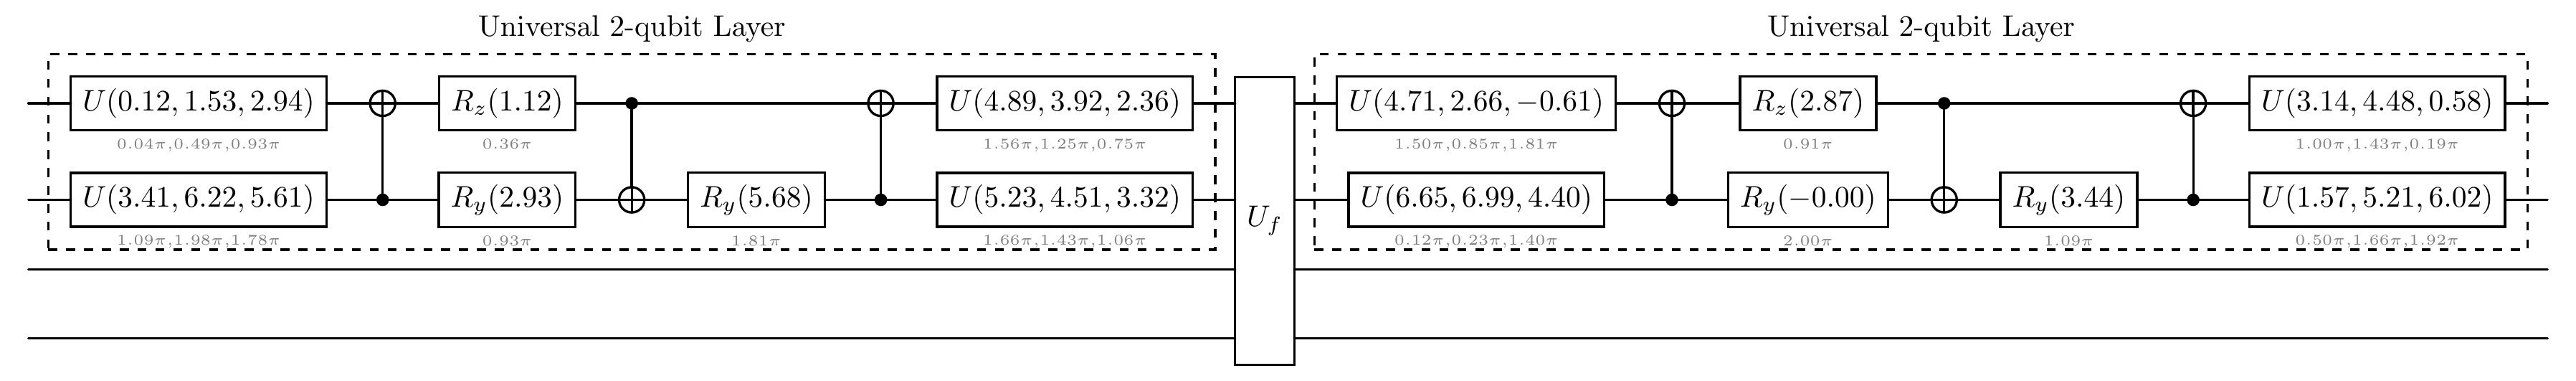

In [17]:
print("the diagram of the quantum circuit after trained:")
cir.plot(style="detailed")

---

## References

[1] M. A. Shafique, A. Munir and I. Latif, "Quantum Computing: Circuits, Algorithms, and Applications," in IEEE Access, vol. 12, pp. 22296-22314, 2024, doi: 10.1109/ACCESS.2024.3362955.

[2] J. Eisert, M.M. Wolf. "Quantum computing." arXiv preprint arXiv:quant-ph/0401019 (2004).

[3] Peter Shor, [Lecture Note 18](https://math.mit.edu/~shor/435-LN/Lecture_18.pdf), 2022

*Table: A reference of notation conventions in this tutorial.*

| Symbol        | Variant          | Description                               |
|:---------------:|:------------------:|-------------------------------------------|
|$f$| |boolean function|
|$n$| |number of bits|
|$s$|$x$, $y$|$n$-bit string|
|$H$| |Hadamard gate|
|$U$|$U_f$|unitary matrix|
|$P^\perp(s)$| |projector onto space orthogonal to $s$|
|$\theta$| |parameters of circuit|
|$\mathcal{L}(\theta)$| |loss function w.r.t. $\theta$|
|$C_\theta(f_i)$ | |output unitary of the parameterized comb $C_\theta$ with input unitary $U_{f_i}$|
|$I$| | identity matrix|

In [18]:
qkit.print_info()


---------VERSION---------
quairkit: 0.4.1
torch: 2.8.0+cpu
numpy: 2.2.6
scipy: 1.15.3
matplotlib: 3.10.5
---------SYSTEM---------
Python version: 3.10.18
OS: Windows
OS version: 10.0.26100
---------DEVICE---------
CPU: ARMv8 (64-bit) Family 8 Model 1 Revision 201, Qualcomm Technologies Inc
